# U.S. Travel Records in 2016
## Data Engineering Capstone Project

### Project Summary
In this project, I use what I have learned throughout the Data Engineering Nanodegree to prepare an end-to-end data pipeline for various data sources dealing with travel into the U.S. in 2016.  The main dataset contains over 36 millions rows of data.

The project entails the following steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
import numpy as np
import pandas as pd
import glob

## Step 1: Scope the Project and Gather Data

### Scope 
The intended purpose of the final data model is to create an accessible database for analysis of travel into the US in 2016.  There are a lot of data and features to look at, feature selection if you will, so I decide to aggregate the travel data by country of residence, port of entry, intended destination and time (month), with an average age calculated for each group.  

The initial data exploration is done with Pandas in Python.  Additional cleaning up and aggregation are done in Apache Spark.  The final database is to be hosted on a system that supports heavy analytics processing, such as Amazon Redshift.

### Describe and Gather Data 
The bulk of the data comes from the US National Tourism and Trade Office https://travel.trade.gov/research/reports/i94/historical/2016.html.  Since this project is purely for academic purposes, I have made the files available on S3.

In [2]:
# data may be downloaded by uncommenting the following lines
# !wget https://jt0321.s3.amazonaws.com/data/18-83510-I94-Data-2016.tar.gz
# !tar -xzvf 18-83510-I94-Data-2016.tar.gz -C ./data

The other datasets I use consist of US Demographics from https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/, and Airport Codes from https://datahub.io/core/airport-codes.

## Step 2: Explore and Assess the Data
### Exploring the Data and Cleaning Steps

**_I94 Immigration Data_**

According to the SAS Labels descriptions file (`I94_SAS_Labels_Descriptions.SAS`), quite a few columns in the main travel files were not filled out, so I limit my analysis to those columns with known values.

In [3]:
valid_cols = ['i94yr', 'i94mon', 'i94res', 'i94port', 'arrdate', 'i94mode', 'i94addr', 'depdate', 'i94bir', 'i94visa', 'count', 'matflag', 'biryear', 'gender', 'insnum', 'airline', 'admnum', 'fltno', 'visatype']

I do initial exploration of the datasets with Pandas, including examining missing values in proportion to total number of rows per data table.

The travel data files are huge, as in over 3 million lines each month.  Further exploration and cleaning are done with Spark in the later steps.

In [4]:
fnames = sorted(glob.glob('data/18-83510-I94-Data-2016/*.sas7bdat'))
print(fnames)

['data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_aug16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_may16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_nov16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_oct16_sub.sas7bdat', 'data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat']


In [5]:
df_sas = pd.read_sas(fnames[0], 'sas7bdat', encoding="ISO-8859-1")

In [6]:
df_sas = df_sas[valid_cols]

In [7]:
df_sas.head(10)

,i94yr,i94mon,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,matflag,biryear,gender,insnum,airline,admnum,fltno,visatype
0,2016.0,4.0,692.0,XXX,20573.0,NaN,NaN,NaN,37.0,2.0,1.0,NaN,1979.0,NaN,NaN,NaN,1.897628e+09,NaN,B2
1,2016.0,4.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,NaN,1991.0,M,NaN,NaN,3.736796e+09,00296,F1
2,2016.0,4.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,M,1961.0,M,NaN,OS,6.666432e+08,93,B2
3,2016.0,4.0,101.0,NYC,20545.0,1.0,MA,20567.0,28.0,2.0,1.0,M,1988.0,NaN,NaN,AA,9.246846e+10,00199,B2
4,2016.0,4.0,101.0,NYC,20545.0,1.0,MA,20567.0,4.0,2.0,1.0,M,2012.0,NaN,NaN,AA,9.246846e+10,00199,B2
5,2016.0,4.0,101.0,NYC,20545.0,1.0,MI,20555.0,57.0,1.0,1.0,M,1959.0,NaN,NaN,AZ,9.247104e+10,00602,B1
6,2016.0,4.0,101.0,NYC,20545.0,1.0,NJ,20558.0,63.0,2.0,1.0,M,1953.0,NaN,NaN,AZ,9.247140e+10,00602,B2
7,2016.0,4.0,101.0,NYC,20545.0,1.0,NJ,20558.0,57.0,2.0,1.0,M,1959.0,NaN,NaN,AZ,9.247161e+10,00602,B2
8,2016.0,4.0,101.0,NYC,20545.0,1.0,NY,20553.0,46.0,2.0,1.0,M,1970.0,NaN,NaN,AZ,9.247080e+10,00602,B2
9,2016.0,4.0,101.0,NYC,20545.0,1.0,NY,20562.0,48.0,1.0,1.0,M,1968.0,NaN,NaN,AZ,9.247849e+10,00608,B1


In [8]:
len(df_sas)

3096313

In [9]:
total_sas = df_sas.isnull().sum().sort_values(ascending=False)
percent_sas = (df_sas.isnull().sum()/len(df_sas)).sort_values(ascending=False)
missing_data_sas = pd.concat([total_sas, percent_sas], axis=1, keys=['Total', 'Percent'])

In [10]:
missing_data_sas

,Total,Percent
insnum,2982605,0.963276
gender,414269,0.133794
i94addr,152592,0.049282
depdate,142457,0.046009
matflag,138429,0.044708
airline,83627,0.027009
fltno,19549,0.006314
biryear,802,0.000259
i94bir,802,0.000259
i94mode,239,0.000077


Even accounting for columns known to have missing data, I still find a large number of null values.  Since I define the scope of my analysis earlier, the presence of missing data for certain aspects may not be that critical.  For isntance, 'INSNUM' is likely an identification number and probably scrubbed from the data set prior to publication.

Also unexpected to me is the presence of international cities, such as [preclearance locations](https://www.cbp.gov/border-security/ports-entry/operations/preclearance) outside the US.

**_Airport Codes_**

In [11]:
df_air = pd.read_csv('airport-codes_csv.csv')

In [12]:
df_air.head(10)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"
5,00AS,small_airport,Fulton Airport,1100.0,NaN,US,US-OK,Alex,00AS,NaN,00AS,"-97.8180194, 34.9428028"
6,00AZ,small_airport,Cordes Airport,3810.0,NaN,US,US-AZ,Cordes,00AZ,NaN,00AZ,"-112.16500091552734, 34.305599212646484"
7,00CA,small_airport,Goldstone /Gts/ Airport,3038.0,NaN,US,US-CA,Barstow,00CA,NaN,00CA,"-116.888000488, 35.350498199499995"
8,00CL,small_airport,Williams Ag Airport,87.0,NaN,US,US-CA,Biggs,00CL,NaN,00CL,"-121.763427, 39.427188"
9,00CN,heliport,Kitchen Creek Helibase Heliport,3350.0,NaN,US,US-CA,Pine Valley,00CN,NaN,00CN,"-116.4597417, 32.7273736"


In [13]:
len(df_air)

55075

In [14]:
len(df_air[df_air['iso_country']=='US'])

22757

In [15]:
df_air.groupby(['iso_country']).size().nlargest(10)

iso_country
US    22757
BR     4334
CA     2784
AU     1963
KR     1376
MX     1181
RU     1040
DE      947
GB      911
FR      850
dtype: int64

In [16]:
total_air = df_air.isnull().sum().sort_values(ascending=False)
percent_air = (df_air.isnull().sum()/len(df_air)).sort_values(ascending=False)
missing_data_air = pd.concat([total_air, percent_air], axis=1, keys=['Total', 'Percent'])

In [17]:
missing_data_air

,Total,Percent
iata_code,45886,0.833155
continent,27719,0.503296
local_code,26389,0.479147
gps_code,14045,0.255016
elevation_ft,7006,0.127208
municipality,5676,0.103059
iso_country,247,0.004485
coordinates,0,0.000000
iso_region,0,0.000000
name,0,0.000000


Most surprising to me about this data set is that the IATA code, with which most travelers would be familiar, is almost entirely absent.

In [18]:
df_air.loc[(df_air['municipality']=='New York') & (df_air['iso_country']=='US')]

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
7431,6N5,heliport,East 34th Street Heliport,10.0,NaN,US,US-NY,New York,6N5,TSS,6N5,"-73.97209930419922, 40.74259948730469"
7432,6N6,seaplane_base,Evers Seaplane Base,NaN,NaN,US,US-NY,New York,6N6,NaN,6N6,"-73.81620025634766, 40.84590148925781"
7433,6N7,seaplane_base,New York Skyports Inc Seaplane Base,NaN,NaN,US,US-NY,New York,NaN,QNY,6N7,"-73.9729, 40.734001"
25070,JPB,closed,Pan Am Building Heliport,870.0,NaN,US,US-NY,New York,NaN,JPB,NaN,"-73.9765, 40.7533"
25072,JRA,heliport,West 30th St. Heliport,7.0,NaN,US,US-NY,New York,KJRA,JRA,JRA,"-74.007103, 40.754501"
25073,JRB,heliport,Downtown-Manhattan/Wall St Heliport,7.0,NaN,US,US-NY,New York,KJRB,JRB,JRB,"-74.00900269, 40.70119858"
27679,KJFK,large_airport,John F Kennedy International Airport,13.0,NaN,US,US-NY,New York,KJFK,JFK,JFK,"-73.77890015, 40.63980103"
27819,KLGA,large_airport,La Guardia Airport,21.0,NaN,US,US-NY,New York,KLGA,LGA,LGA,"-73.87259674, 40.77719879"
28248,KNOP,closed,Floyd Bennett Field,16.0,NaN,US,US-NY,New York,NaN,NaN,NaN,"-73.890999, 40.591"
36260,NK39,heliport,One Police Plaza Heliport,244.0,NaN,US,US-NY,New York,NK39,NaN,NK39,"-73.99960327148438, 40.71260070800781"


There are also a lot of 'ports' that qualify in the broadest definition of airport.  I doubt the majority of immigration occurs via heliport.

In [19]:
df_air.type.unique()

array(['heliport', 'small_airport', 'closed', 'seaplane_base',
       'balloonport', 'medium_airport', 'large_airport'], dtype=object)

In [20]:
df_air = df_air[(df_air['type'] == 'small_airport')|(df_air['type'] == 'medium_airport')|(df_air['type'] == 'large_airport')]

In [21]:
df_air = df_air[['ident', 'name', 'type', 'iso_country', 'iso_region', 'municipality']]

In [22]:
len(df_air)

39142

In [23]:
df_air.loc[(df_air['municipality']=='New York') & (df_air['iso_country']=='US')]

,ident,name,type,iso_country,iso_region,municipality
27679,KJFK,John F Kennedy International Airport,large_airport,US,US-NY,New York
27819,KLGA,La Guardia Airport,large_airport,US,US-NY,New York
49898,US-0883,JFK,large_airport,US,US-NY,New York


After limiting the data to commercial airports only, linking airports to cities is still not an unambiguous task.

**_U.S. City Demographic Data_**

In [24]:
df_cities = pd.read_csv('us-cities-demographics.csv', sep=';')

In [25]:
df_cities.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [26]:
len(df_cities)

2891

In [27]:
df_cities.sort_values(by="Foreign-born", ascending=False).head(10)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
2494,New York,New York,36.0,4081698.0,4468707.0,8550405,156961.0,3212500.0,2.68,NY,Black or African-American,2192248
1826,New York,New York,36.0,4081698.0,4468707.0,8550405,156961.0,3212500.0,2.68,NY,White,3835726
2304,New York,New York,36.0,4081698.0,4468707.0,8550405,156961.0,3212500.0,2.68,NY,American Indian and Alaska Native,90923
2225,New York,New York,36.0,4081698.0,4468707.0,8550405,156961.0,3212500.0,2.68,NY,Asian,1304564
2493,New York,New York,36.0,4081698.0,4468707.0,8550405,156961.0,3212500.0,2.68,NY,Hispanic or Latino,2485125
40,Los Angeles,California,35.0,1958998.0,2012898.0,3971896,85417.0,1485425.0,2.86,CA,White,2177650
2392,Los Angeles,California,35.0,1958998.0,2012898.0,3971896,85417.0,1485425.0,2.86,CA,Hispanic or Latino,1936732
2883,Los Angeles,California,35.0,1958998.0,2012898.0,3971896,85417.0,1485425.0,2.86,CA,Black or African-American,404868
535,Los Angeles,California,35.0,1958998.0,2012898.0,3971896,85417.0,1485425.0,2.86,CA,Asian,512999
1714,Los Angeles,California,35.0,1958998.0,2012898.0,3971896,85417.0,1485425.0,2.86,CA,American Indian and Alaska Native,63758


This data set is essentially replicated four times over if we do not account for race.  Since race cannot be exactly tied to location data, for the scope of this project I think it best to drop it.

In [28]:
#df_cities = df_cities.drop(['Race', 'Count'], axis=1).drop_duplicates().sort_values(by="Foreign-born", ascending=False)
df_cities = df_cities[['City', 'State Code', 'Median Age', 'Total Population', 'Foreign-born']] \
  .drop_duplicates() \
  .sort_values(by="Foreign-born", ascending=False) \
  .reset_index()

In [29]:
df_cities['Foreign-born %'] = 100*df_cities['Foreign-born']/df_cities['Total Population']

In [30]:
df_cities.head(10)

,index,City,State Code,Median Age,Total Population,Foreign-born,Foreign-born %
0,1826,New York,NY,36.0,8550405,3212500.0,37.571320
1,40,Los Angeles,CA,35.0,3971896,1485425.0,37.398386
2,254,Houston,TX,32.6,2298628,696210.0,30.288067
3,864,Chicago,IL,34.2,2720556,573463.0,21.078890
4,561,San Jose,CA,36.5,1026919,401493.0,39.096852
5,236,San Diego,CA,34.5,1394907,373842.0,26.800496
6,538,Dallas,TX,32.6,1300082,326825.0,25.138799
7,337,Phoenix,AZ,33.8,1563001,300702.0,19.238759
8,945,San Francisco,CA,38.3,864816,297199.0,34.365576
9,1420,Miami,FL,40.4,440989,260789.0,59.137303


I add an additional column for the percentage of each city's population that is foreign-born.

### Data Wrangling with Spark

In [31]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [32]:
from pyspark.sql import functions as F

In [33]:
df_spark = spark.read.format('com.github.saurfang.sas.spark').load(fnames[0])

In [34]:
from pyspark.sql import functions as F

df_spark.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+-----+--------+
|cicid|i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|  occup|entdepa|entdepd|entdepu|matflag|biryear|dtaddto|gender| insnum|airline|admnum|fltno|visatype|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+-----+--------+
|    0|    0|     0|     0|     0|      0|      0|    239| 152592| 142457|   802|      0|    0|       1| 1881250|3088187|    238| 138429|3095921| 138429|    802|    477|414269|2982605|  83627|     0|19549|       0|
+-----+-----+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-------+-------+-------+---

I get the same numbers as with Pandas when examining null values with Spark.

In [76]:
df_agg = df_spark.select(['i94yr', 'i94mon', 'i94res', 'i94port', 'i94bir', 'i94addr']) \
  .groupBy(['i94yr', 'i94mon', 'i94res', 'i94port', 'i94addr']) \
  .agg(F.mean(df_spark.i94bir).alias('age_mean'), F.count(df_spark.i94bir).alias('count'))

In [77]:
df_agg.show(20)

+------+------+------+-------+-------+------------------+-----+
| i94yr|i94mon|i94res|i94port|i94addr|          age_mean|count|
+------+------+------+-------+-------+------------------+-----+
|2016.0|   4.0| 104.0|    MIA|     NY|              46.0|   40|
|2016.0|   4.0| 107.0|    DAL|     IL|              40.2|    5|
|2016.0|   4.0| 112.0|    ATL|     SC| 45.74647887323944|  426|
|2016.0|   4.0| 108.0|    NEW|     DE|              51.4|    5|
|2016.0|   4.0| 111.0|    WAS|     GA|              39.6|    5|
|2016.0|   4.0| 116.0|    DUB|     IA| 37.07142857142857|   28|
|2016.0|   4.0| 690.0|    MIA|     UN| 40.15151515151515|  198|
|2016.0|   4.0| 135.0|    PIT|     MA|              55.0|    3|
|2016.0|   4.0| 213.0|    DAL|     IN| 35.88235294117647|   17|
|2016.0|   4.0| 514.0|    TAM|     VQ|28.833333333333332|    6|
|2016.0|   4.0| 582.0|    OTT|     CA|              30.0|    1|
|2016.0|   4.0| 691.0|    MON|     NC|              65.0|    1|
|2016.0|   4.0| 131.0|    LIH|     NV|  

In [37]:
df_agg.count()

88996

88,996 lines is a much more manageable number than 3,096,313.

In [79]:
df_agg = df_agg.fillna({'i94addr':'99'})

In [80]:
df_agg.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_agg.columns]).show()

+-----+------+------+-------+-------+--------+-----+
|i94yr|i94mon|i94res|i94port|i94addr|age_mean|count|
+-----+------+------+-------+-------+--------+-----+
|    0|     0|     0|      0|      0|      13|    0|
+-----+------+------+-------+-------+--------+-----+



I replace null values for 'i94addr' with '99' representing 'invalid codes.'

In [38]:
from helpers import ports, res

In [48]:
res_sub = F.udf(lambda x: res[str(int(x))] if str(int(x)) in res.keys() else str(int(x)))
ports_sub = F.udf(lambda x: ports[str(x)] if str(x) in ports.keys() else str(x))

In [81]:
df_agg = df_agg \
  .withColumn('res', res_sub(df_spark.i94res)) \
  .withColumn('port', ports_sub(df_spark.i94port))

In [82]:
df_agg.show(20)

+------+------+------+-------+-------+------------------+-----+--------------------+--------------------+
| i94yr|i94mon|i94res|i94port|i94addr|          age_mean|count|                 res|                port|
+------+------+------+-------+-------+------------------+-----+--------------------+--------------------+
|2016.0|   4.0| 104.0|    MIA|     NY|              46.0|   40|             BELGIUM|           MIAMI, FL|
|2016.0|   4.0| 107.0|    DAL|     IL|              40.2|    5|              POLAND|          DALLAS, TX|
|2016.0|   4.0| 112.0|    ATL|     SC| 45.74647887323944|  426|             GERMANY|         ATLANTA, GA|
|2016.0|   4.0| 108.0|    NEW|     DE|              51.4|    5|             DENMARK|NEWARK/TETERBORO, NJ|
|2016.0|   4.0| 111.0|    WAS|     GA|              39.6|    5|              FRANCE|       WASHINGTON DC|
|2016.0|   4.0| 116.0|    DUB|     IA| 37.07142857142857|   28|             IRELAND|     DUBLIN, IRELAND|
|2016.0|   4.0| 690.0|    MIA|     UN| 40.1515

With a little VS Code keyboard shortcut magic, I create helper dictionaries from `I94_SAS_Labels_Descriptions.SAS` to add columns containing values of the address and port codes.

In [45]:
airports = spark.createDataFrame(df_air.astype(str))

In [46]:
airports.show()

+-----+--------------------+-------------+-----------+----------+------------+
|ident|                name|         type|iso_country|iso_region|municipality|
+-----+--------------------+-------------+-----------+----------+------------+
| 00AA|Aero B Ranch Airport|small_airport|         US|     US-KS|       Leoti|
| 00AK|        Lowell Field|small_airport|         US|     US-AK|Anchor Point|
| 00AL|        Epps Airpark|small_airport|         US|     US-AL|     Harvest|
| 00AS|      Fulton Airport|small_airport|         US|     US-OK|        Alex|
| 00AZ|      Cordes Airport|small_airport|         US|     US-AZ|      Cordes|
| 00CA|Goldstone /Gts/ A...|small_airport|         US|     US-CA|     Barstow|
| 00CL| Williams Ag Airport|small_airport|         US|     US-CA|       Biggs|
| 00FA| Grass Patch Airport|small_airport|         US|     US-FL|    Bushnell|
| 00FL|   River Oak Airport|small_airport|         US|     US-FL|  Okeechobee|
| 00GA|    Lt World Airport|small_airport|         U

In [40]:
cities = spark.createDataFrame(df_cities)

In [41]:
cities.show()

+-----+-------------+----------+----------+----------------+------------+------------------+
|index|         City|State Code|Median Age|Total Population|Foreign-born|    Foreign-born %|
+-----+-------------+----------+----------+----------------+------------+------------------+
| 1826|     New York|        NY|      36.0|         8550405|   3212500.0| 37.57131972111262|
|   40|  Los Angeles|        CA|      35.0|         3971896|   1485425.0|37.398386060460794|
|  254|      Houston|        TX|      32.6|         2298628|    696210.0| 30.28806749069445|
|  864|      Chicago|        IL|      34.2|         2720556|    573463.0|21.078889756358627|
|  561|     San Jose|        CA|      36.5|         1026919|    401493.0| 39.09685184517961|
|  236|    San Diego|        CA|      34.5|         1394907|    373842.0|26.800496377177833|
|  538|       Dallas|        TX|      32.6|         1300082|    326825.0|  25.1387989372978|
|  337|      Phoenix|        AZ|      33.8|         1563001|    300702

In [42]:
# courtesy of https://stackoverflow.com/questions/53486981/how-to-return-rows-with-null-values-in-pyspark-dataframe

from functools import reduce

cities.where(reduce(lambda x, y: x | y, (F.col(x).isNull()|F.isnan(x) for x in cities.columns))).show()

+-----+--------+----------+----------+----------------+------------+--------------+
|index|    City|State Code|Median Age|Total Population|Foreign-born|Foreign-born %|
+-----+--------+----------+----------+----------------+------------+--------------+
|  111|San Juan|        PR|      41.4|          342237|         NaN|           NaN|
|  155|  Caguas|        PR|      40.4|           77008|         NaN|           NaN|
|  258|Carolina|        PR|      42.0|          142066|         NaN|           NaN|
| 1748|Mayagüez|        PR|      38.1|           66581|         NaN|           NaN|
| 1995|   Ponce|        PR|      40.5|          121583|         NaN|           NaN|
| 2004| Bayamón|        PR|      39.4|          170259|         NaN|           NaN|
| 2589|Guaynabo|        PR|      42.2|           70492|         NaN|           NaN|
+-----+--------+----------+----------+----------------+------------+--------------+



I create Spark dataframes from the Pandas dataframes.

It bothers me to know there are null values in the cities data, so I find where they are for my peace of mind.  Their presence should not impact the rest of the analysis greatly.  Otherwise, for the relevant columns, the dataset is complete.

## Step 3: Define the Data Model
### 3.1 Conceptual Data Model

The data model thus far follows the following simple schema.

**__Facts__**  
Intake into US

**__Dimensions__**  
US Cities  
Airports

The tables are normalized as best as I could manage, though not completely.  For instance, US state cannot be considered a primary key for any of the tables.

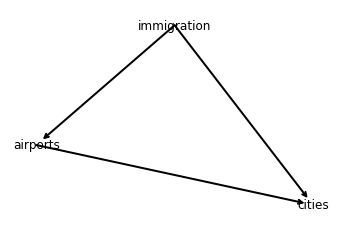

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()


g.add_edges_from([(1,2), (1,3), (2,3)])
pos = {1:(20, 40), 2: (10,20), 3: (30,10)}
labels = {1:'immigration', 2:'airports', 3:'cities'}

edges = nx.draw_networkx_edges(g, pos, arrowstyle='->',
                               arrowsize=10, width=2)
nx.draw_networkx_labels(g, pos, labels)

plt.axis('off')
plt.show()

These are the facts and dimensions as best as I can convey via a simple graph.

### 3.2 Mapping Out Data Pipelines

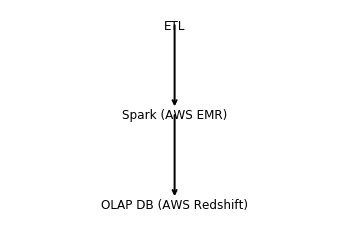

In [117]:
g = nx.DiGraph()

g.add_edges_from([(1,2), (2,3)])

pos = {1:(10, 40), 2: (10,30), 3: (10,20)}
labels = {1:'ETL', 2:'Spark (AWS EMR)', 3:'OLAP DB (AWS Redshift)'}

edges = nx.draw_networkx_edges(g, pos, arrowstyle='->',
                               arrowsize=10, width=2)
nx.draw_networkx_labels(g, pos, labels)

plt.axis('off')
plt.show()

And here is a simple graph of the data pipeline.

## Step 4: Run Pipelines to Model the Data 
### 4.1 Create the data model
In practice, I would read the dataset files with Spark, but since I had already done data cleaning with Pandas, I simply create Spark Dataframes from the Pandas Dataframes.  At any rate, the bulk of the data is in the NTTO dataset, and the following function reads each SAS file and processes it for loading into my pipeline.

In [84]:
def agg_month(spark, file):
    mon = spark.read.format('com.github.saurfang.sas.spark').load(file)
    mon = mon.select(['i94yr', 'i94mon', 'i94res', 'i94port', 'i94bir', 'i94addr']) \
        .groupBy(['i94yr', 'i94mon', 'i94res', 'i94port', 'i94addr']) \
        .agg(F.mean(mon.i94bir).alias('age_mean'), F.count(mon.i94bir).alias('count'))
    mon = mon.fillna({'i94addr':'99'})
    mon = mon.withColumn('res', res_sub(mon.i94res)).withColumn('port', ports_sub(mon.i94port))
    return mon

In [85]:
for f in fnames[1:]:
    df_agg = df_agg.union(agg_month(spark, f))

In [87]:
#write to parquet
df_agg.write.parquet("sas")

In [11]:
df_agg=spark.read.parquet("sas")

The aggregated data is written into parquet files to be uploaded into Amazon EMR for further analysis.

### 4.2 Data Quality Checks

In [86]:
df_agg.count()

797180

In [88]:
df_agg.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df_agg.columns]).show()

+-----+------+------+-------+-------+--------+-----+---+----+
|i94yr|i94mon|i94res|i94port|i94addr|age_mean|count|res|port|
+-----+------+------+-------+-------+--------+-----+---+----+
|    0|     0|     0|      0|      0|     144|    0|  0|   0|
+-----+------+------+-------+-------+--------+-----+---+----+



The total number of rows and null values seem appropriate after clean-up and aggregation.

### 4.3 Data dictionary 

(also included as `data_dictionary.md`)

from the NTTO dataset

- i94yr: year of travel
- i94mon: month of travel
- i94res: code for country of origin
- res: long-form country of origin
- i94port: code for port of entry
- port: long-form port of entry
- i94bir: age in years
- i94addr: intended destination, as in state
- age_mean: mean age of each aggregated group
- count: number of members in each aggregated group

from the airports dataset

- ident: airport code, generally the ICAO code; can be considered the primary key for this table
- name: name of airport
- type: type of airport; possible values are small_airport, medium_airport and large_airport
- iso_country: country
- iso_region: country and state/province
- municipality: city or metropolitan area in which airport situated

from the cities dataset (self-explanatory)

- City: can be considered the primary key for this table
- State Code
- Median Age
- Total Population
- Foreign-born
- Foreign-born %

## Step 5: Write Up

**_Choice of tools, technologies and data model_**

Pandas is used initially to explore the data files due to its ease of use and many features.

Due to the sizes of the files involved, Apache Spark is the main analytics engine used to aggregate the data.  According to the scope of analysis I define in the beginning, a monthly update of data is ideal, and could be automated with a tool like Apache Airflow.  After the large data files have been processed, off-loading to an online database for analysis is possible, with Spark for initial ingestion of bulk data.  AWS EMR is a possible service for continued analysis with Spark.

The data model is chosen partly to reflect the immigration process, and due to the inherent relationships between locations.  No obvious one-to-one correspondence exists between all locations, thus I decide not to merge the tables.

A few hypothetical scenarios from this process could arise, which I now address.

**_If the data was increased by 100x_**

If the data were to increase in size by 100, I would change the scope of analysis depending on which part increased.  I am not sure how immigration can increase by 100 times, but 100 times more information could be collected, e.g., IoT data collection, additional activity information from each traveler, using machine learning to identify suspicious elements, etc.  In such a case the dataset may need to be subdivided geographically and partitioned for analyses as appropriate.  I might also change the time granularity of analysis to yearly influx of travelers as opposed to monthly.  

**_If the pipelines were run on a daily basis by 7am_**

If this pipeline needed to be run daily, I would use Apache Airflow to schedule tasks.  The aggregation of travelor records would still only occur monthly.  The scheduled daily task would check for updates or corrections to existing datasets and repopulate the analytical tables as necessary, using complex logic to figure out backfills and deduplication and such.  For the most part, requiring daily updates would shift the entire scope of the project and I would need to reconsider the data pipeline.

**_If the database needed to be accessed by 100+ people_**

If the database needed to be accessed by more than 100 people, the most important aspects would be availability and reliability..  I would use a database optimized for OLAP, such as Amazon Redshift, and possibly with additional caching features if the people that needed access were located far apart geographically.  Scalability would also be a concern as the database grows, though I expect usage of the data to be read-heavy, not write-heavy.